In [42]:
import getpass
import os

os.environ["OPENAI_API_KEY"] = getpass.getpass()

from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o-mini")

In [43]:
from langchain_core.messages import HumanMessage, SystemMessage

messages = [
    SystemMessage("Translate the following from English into Italian"),
    HumanMessage("hi!"),
]

model.invoke(messages)

AIMessage(content='Ciao!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 3, 'prompt_tokens': 20, 'total_tokens': 23, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_818c284075', 'finish_reason': 'stop', 'logprobs': None}, id='run-63549dad-7e37-4799-bea0-14d07447ef7b-0', usage_metadata={'input_tokens': 20, 'output_tokens': 3, 'total_tokens': 23, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

## Part 1: Build a Basic Chatbot

In [4]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages : Annotated[list, add_messages]

graph_builder = StateGraph(State)

Our graph can now handle two key tasks:

1) Each node can receive the current State as input and output an update to the state.
2) Updates to messages will be appended to the existing list rather than overwriting it, thanks to the prebuilt add_messages function used with the Annotated syntax

In [5]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

In [6]:
graph_builder.add_edge(START, "chatbot")

graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

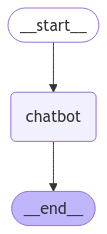

In [7]:
# Visualizing the graph

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [8]:
# Running the chatbot

def stream_graph_updates(user_input:str):
    for event in graph.stream({"messages":[("user", user_input)]}):
        for value in event.values():
            print("Assistant : ", value["messages"][-1].content)

while True:
    user_input = input("User : ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    stream_graph_updates(user_input)

Goodbye!


### Full Code of the Part 1

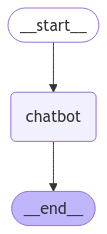

Goodbye!


In [9]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages : Annotated[list, add_messages]

graph_builder = StateGraph(State)

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

graph_builder.add_edge(START, "chatbot")

graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

# Visualizing the graph

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

# Running the chatbot

def stream_graph_updates(user_input:str):
    for event in graph.stream({"messages":[("user", user_input)]}):
        for value in event.values():
            print("Assistant : ", value["messages"][-1].content)

while True:
    user_input = input("User : ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    stream_graph_updates(user_input)

## Part 2: Enhancing the Chatbot with Tools

To handle queries our chatbot can't answer "from memory", we'll integrate a web search tool. Our bot can use this tool to find relevant information and provide better responses.

In [2]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")

In [3]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("Who won the Oscar for best actor in 2024?")

[{'url': 'https://www.cbsnews.com/news/oscar-winners-2024-list/',
  'content': 'Best picture\nBest supporting actress\nBest animated short film\nBest animated feature film\nBest original screenplay\nBest adapted screenplay\nBest makeup and hairstyling\nBest production design\nBest costume design\nBest international feature film\nBest supporting actor\nBest visual effects\nBest film editing\nBest documentary short film\nBest documentary feature film\nBest cinematography\nBest live action short film\nBest sound\nBest original score\nBest original song\nBest actor\nBest director\nBest actress\nFull list of Oscars 2024 winners\nThe 2024 Oscars\nJordan Freiman is an editor and writer for CBSNews.com. See the full list of Academy Award winners\nBy Jordan Freiman\nUpdated on:\nMarch 10, 2024 / 11:42 PM EDT\n/ CBS News\n"Oppenheimer" won big at the 2024 Oscars, coming in with 13 nominations and earning awards in major categories such as best director, best actor and best picture.\n The full li

In [4]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI

class State(TypedDict):
    messages : Annotated[list, add_messages]

graph_builder = StateGraph(State)

llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

In [13]:
import json
from langchain_core.messages import ToolMessage

class BasicToolNode:
    
    def __init__(self, tools:list) -> None:
        self.tools_by_name = {tool.name:tool for tool in tools}
    
    def __call__(self, inputs: dict):
        if messages:= inputs.get("messages", []):
            messages = messages[-1]
        else:
            raise ValueError("No message found in input..!")
        
        outputs = []
        for tool_call in messages.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content = json.dumps(tool_result),
                    name = tool_call["name"],
                    tool_call_id = tool_call["id"],
                )
            )
        return {"messages": outputs}

tool_node = BasicToolNode(tools = [tool])
graph_builder.add_node("tools", tool_node)

Conditional edges usually contain "if" statements to route to different nodes depending on the current graph state. These functions receive the current graph state and return a string or list of strings indicating which node(s) to call next.

In [14]:
from typing import Literal 

def route_tools(state: State):
    if isinstance(state,list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"NO messages found in input state to tool edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END

graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    {"tools":"tools", END:END}
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

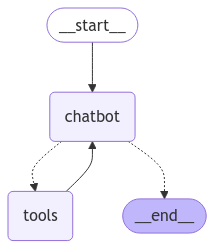

In [15]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [16]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break

    stream_graph_updates(user_input)


Assistant: 
Assistant: [{"url": "https://www.indiatoday.in/sports/story/cricket-r-ashwin-chennai-super-kings-csk-ipl-2025-mega-auction-2639346-2024-11-24", "content": "Star India off spinner Ravichandran Ashwin was bought by five-time champions Chennai Super Kings for INR 9.75 Crore at the IPL 2025 mega auction. ... News Sports IPL Auction: CSK buy R Ashwin for 9.75 crore, spinner re-unites with MS Dhoni. Sports. ... Ashwin didn't have a memorable season in 2024 as he could only scalp nine wickets from 15"}, {"url": "https://sportstar.thehindu.com/cricket/ipl/ipl-news/ashwin-signed-sold-chennai-super-kings-csk-ipl-mega-auction-bid-update-news/article68905455.ece", "content": "Ravichandran Ashwin signed by CSK for Rs 9.75 crore in IPL 2025 auction IPL auction 2025 update: Ashwin was released by Rajasthan Royals ahead of this year's auction after representing the outfit in the 2024 season. Published : Nov 24, 2024 18:58 IST , CHENNAI - 1 MIN READ"}]
Assistant: Ravichandra Ashwin was boug

Created a conversational agent in langgraph that can use a search engine to retrieve updated information when needed. Now it can handle a wider range of user queries.

## Part 3: Adding Memory to the Chatbot

Our chatbot can now use tools to answer user questions, but it doesn't remember the context of previous interactions. This limits its ability to have coherent, multi-turn conversations.

In [17]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [19]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages : Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearchResults(max_results=1)
tools = [tool]

llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [20]:
graph = graph_builder.compile(checkpointer=memory)

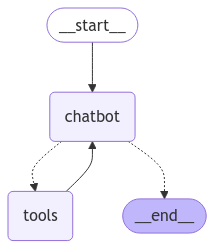

In [21]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [22]:
config = {"configurable": {"thread_id": "1"}}

user_input = "Hi there! My name is Will."
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hi Will! How can I assist you today?


In [23]:
user_input = "Remember my name?"

events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, your name is Will! How can I help you today?


In [24]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='e06f1dae-e9ea-49fb-acf4-b376cd144e7e'), AIMessage(content='Hi Will! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 15, 'total_tokens': 25, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_bba3c8e70b', 'finish_reason': 'stop', 'logprobs': None}, id='run-9b225b70-7708-4f39-bf86-91fa344daf4b-0', usage_metadata={'input_tokens': 15, 'output_tokens': 10, 'total_tokens': 25, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage(content='Remember my name?', additional_kwargs={}, r

In [25]:
snapshot.next

()

Chatbot can now maintain conversation state across sessions thanks to LangGraph's checkpointing system. This opens up exciting possibilities for more natural, contextual interactions. LangGraph's checkpointing even handles arbitrarily complex graph states, which is much more expressive and powerful than simple chat memory.

## Part 4: Human-in-the-loop

Agents can be unreliable and may need human input to successfully accomplish tasks. Similarly, for some actions, you may want to require human approval before running to ensure that everything is running as intended.

In [5]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages : Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearchResults(max_results=2)
tools = [tool]

llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [30]:
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["tools"]
)

In [34]:
user_input = "I'm learning LangChain. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangChain. Could you do some research on it for me?
================================== Ai Message ==================================

Certainly! Here’s an overview of LangChain, which is a popular framework for building applications that utilize large language models (LLMs).

### Overview of LangChain

**LangChain** is a framework designed to simplify the development of applications that leverage the capabilities of large language models. It allows developers to create more complex and capable applications by chaining together various components and functionalities.

### Key Features

1. **Modular Components**: LangChain is built with a modular architecture, making it easy to mix and match components depending on your application's needs. This includes tools for memory, data loading, and model interaction.

2. **Chains**: One of the core concepts of LangChain is the ability to create "chains"

## Part 5: Manually Updating the State

Updating the state lets you control the agent's trajectory by modifying its actions (even modifying the past!). This capability is particularly useful when you want to correct the agent's mistakes, explore alternative paths, or guide the agent towards a specific goal.

In [8]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

class State(TypedDict):
    messages : Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearchResults(max_results=2)
tools = [tool]

llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["tools"]
)

user_input = "I'm learning LangGraph. Could you do some research on it for me? To get the most up to date information please use tavily search engine"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream({"messages": [("user", user_input)]}, config)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

In [9]:
snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
existing_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_i8iB6LzHtvDPYT8r7ssA7xkC)
 Call ID: call_i8iB6LzHtvDPYT8r7ssA7xkC
  Args:
    query: LangGraph


Now what if we intervene not let the agent use the search engine, and we ourself provide the result for it...!


In [10]:
from langchain_core.messages import AIMessage, ToolMessage

answer = ("LangGraph is a library for building stateful, multi-actor applications with LLMs.")

new_message = [
    ToolMessage(content=answer, tool_call_id=existing_message.tool_calls[0]["id"]),
    AIMessage(content=answer)
]

new_message[-1].pretty_print()
graph.update_state(
    config,
    {"messages":new_message}
)

print("\n\nLast 2 messages;")
print(graph.get_state(config).values["messages"][-2:])

================================== Ai Message ==================================

LangGraph is a library for building stateful, multi-actor applications with LLMs.


Last 2 messages;
[ToolMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='b0d02b96-e709-4bdb-90d5-5bb623d61f6c', tool_call_id='call_i8iB6LzHtvDPYT8r7ssA7xkC'), AIMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', additional_kwargs={}, response_metadata={}, id='c694af91-ac3b-4f82-8f68-439ec6dfaceb')]


In [11]:
graph.update_state(
    config, 
    {"messages": [AIMessage(content="I'm an AI Expert")]},
    as_node="chatbot"
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efb6d65-4022-6084-8003-e5228a59b531'}}

What if you want to overwrite existing messages?

In [13]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable":{"thread_id":"2"}}
events = graph.stream(
    {"messages":[("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_vwcx3HnvYuNcxr7StKMWbvk9)
 Call ID: call_vwcx3HnvYuNcxr7StKMWbvk9
  Args:
    query: LangGraph


In [14]:
from langchain_core.messages import AIMessage

snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
print("Original")
print("Message_ID", existing_message.id)
print(existing_message.tool_calls[0])

new_tool_call = existing_message.tool_calls[0].copy()
new_tool_call["args"]["query"] = "Langgraph human in the loop workflow"
new_message = AIMessage(
    content = existing_message.content,
    tool_calls = [new_tool_call],
    id = existing_message.id
)

print("Updated")
print(new_message.tool_calls[0])
print("Message ID", new_message.id)
graph.update_state(config, {"messages":[new_message]})

print("\n\nTool Calls")
graph.get_state(config).values["messages"][-1].tool_calls


Original
Message_ID run-1a21a6bd-edb9-4898-a1f4-4601e85ef9f8-0
{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph'}, 'id': 'call_vwcx3HnvYuNcxr7StKMWbvk9', 'type': 'tool_call'}
Updated
{'name': 'tavily_search_results_json', 'args': {'query': 'Langgraph human in the loop workflow'}, 'id': 'call_vwcx3HnvYuNcxr7StKMWbvk9', 'type': 'tool_call'}
Message ID run-1a21a6bd-edb9-4898-a1f4-4601e85ef9f8-0


Tool Calls


[{'name': 'tavily_search_results_json',
  'args': {'query': 'Langgraph human in the loop workflow'},
  'id': 'call_vwcx3HnvYuNcxr7StKMWbvk9',
  'type': 'tool_call'}]

## Part 6: Customizing State

In [15]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

class State(TypedDict):
    messages : Annotated[list, add_messages]
    ask_human = bool

In [16]:
from pydantic import BaseModel

class RequestAssistance(BaseModel):
    request:str

In [17]:
tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])

def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human":ask_human}

In [26]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))

In [27]:
from langchain_core.messages import AIMessage, ToolMessage


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)

In [28]:
def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", END: END},
)

In [29]:
# The rest is the same
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    # We interrupt before 'human' here instead.
    interrupt_before=["human"],
)

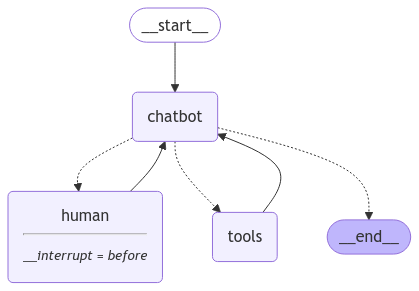

In [30]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [49]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
# NOTE: you must use langchain-core >= 0.3 with Pydantic v2
from pydantic import BaseModel
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(model="gpt-4o-mini")
# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}


graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)


def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", "__end__": "__end__"},
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.set_entry_point("chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["human"],
)

In [50]:
ai_message = snapshot.values["messages"][-1]
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)
tool_message = create_response(human_response, ai_message)
graph.update_state(config, {"messages": [tool_message]})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efb6dc8-3f2e-61f2-8000-c3afe7ed1630'}}

In [51]:
graph.get_state(config).values["messages"]

[ToolMessage(content="We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.", id='e2971a1d-c7c0-411c-a009-13342b985e4e', tool_call_id='call_Xg80XWmuob7IdLE2J0pvCMJG')]

In [54]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
# NOTE: you must use langchain-core >= 0.3 with Pydantic v2
from pydantic import BaseModel
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(model="gpt-4o-mini")
# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}


graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)


def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", "__end__": "__end__"},
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.set_entry_point("chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["human"],
)

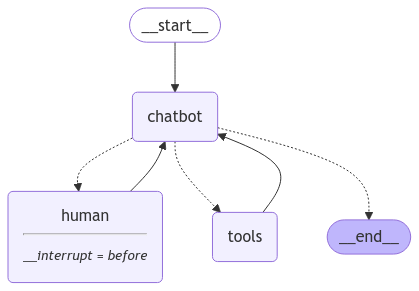

In [55]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [56]:
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {
        "messages": [
            ("user", "I'm learning LangGraph. Could you do some research on it for me?")
        ]
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_0mvqTF5gDetjetIIfdngPWpL)
 Call ID: call_0mvqTF5gDetjetIIfdngPWpL
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.langchain.com/langgraph", "content": "LangGraph is a framework for building and scaling agentic applications with LangChain Platform. It supports diverse control flows, human-agent collaboration, streaming, and deployment options for complex tasks."}, {"url": "https://langchain-ai.github.io/langgraph/", "content": "LangGraph is a low-level framework that allows you to create stateful, multi-actor applications with LLMs, using cycles, controllability, and persistence. Learn how to use Lang

In [61]:
events = graph.stream(
    {
        "messages": [
            ("user", "Ya that's helpful. Maybe I'll build an autonomous agent with it!")
        ]
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it!
================================== Ai Message ==================================

That sounds like a fantastic idea! Building an autonomous agent with LangGraph could lead to some innovative applications. If you need any assistance with concepts, design, or specific functionalities while developing your agent, don't hesitate to reach out. Good luck with your project!


In [62]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next :", state.next)
    print("-"*50)
    if len(state.values["messages"]) == 4:
        to_replay=state

Num Messages:  8 Next : ()
--------------------------------------------------
Num Messages:  7 Next : ('chatbot',)
--------------------------------------------------
Num Messages:  6 Next : ('__start__',)
--------------------------------------------------
Num Messages:  6 Next : ()
--------------------------------------------------
Num Messages:  5 Next : ('chatbot',)
--------------------------------------------------
Num Messages:  4 Next : ('__start__',)
--------------------------------------------------
Num Messages:  4 Next : ()
--------------------------------------------------
Num Messages:  3 Next : ('chatbot',)
--------------------------------------------------
Num Messages:  2 Next : ('tools',)
--------------------------------------------------
Num Messages:  1 Next : ('chatbot',)
--------------------------------------------------
Num Messages:  0 Next : ('__start__',)
--------------------------------------------------


In [63]:
print(to_replay.next)
print(to_replay.config)

()
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efb6dd0-bb97-654b-8003-2563963bd442'}}


In [64]:
# The `checkpoint_id` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

Here are some key resources and information on LangGraph:

1. **LangGraph Overview**:
   - LangGraph is a framework designed for building and scaling agentic applications on the LangChain platform. It supports a variety of control flows, human-agent collaboration, streaming, and various deployment options for handling complex tasks.
   - [LangGraph Official Page](https://www.langchain.com/langgraph)

2. **Features and Functionality**:
   - It is a low-level framework that enables the creation of stateful, multi-actor applications utilizing Large Language Models (LLMs). 
   - LangGraph offers capabilities such as cycles, controllability, and persistence, allowing for robust agent and multi-agent workflows.
   - You can learn how to integrate LangGraph with tools like LangChain, LangSmith, and Anthropic to enhance your projects.
   - [LangGraph Documentation](https://langchain-ai.github.io/langgraph/)

Thes